## Ejercicio 3

In [132]:
import cirq

In [133]:
import matplotlib.pyplot as plt

def plot_histogram(result: dict, width=5) -> None:
    
    counts = sorted(result.items(), key=lambda x: x[0])
    keys = [str(x[0]) for x in counts]
    values = [x[1] for x in counts]
    plt.figure(figsize=(width, 5))
    plt.bar_label(plt.bar(keys, [x / 1000 for x in values]), values)

### QFT

Vamos a implementar el sumador de Draper de 4 bits usando el circuito de la QFT del ejercicio anterior.

Para ello vamos a usar la función que definimos anteriormente.

In [134]:
def QFT(qubits):

    N = len(qubits)
    circuit = cirq.Circuit()

    for i in range(N):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i + 1, N):
            circuit.append(cirq.CZ(qubits[j], qubits[i])**(0.5**(j-i)))

    return circuit

Vamos a definir una función que nos cree la parte intermedia del sumador de Draper.

El circuito consiste en aplicar rotaciones controladas entre los distintos qubits de cada uno de los operandos.

In [135]:
def adder(qubits):
    
    N = len(qubits) // 2
    circuit = cirq.Circuit()

    for i in range(N):
        for j in range(i, N):
            circuit.append(cirq.CZ(qubits[N + j], qubits[i])**(0.5**(j-i)))

    return circuit

# Probamos la función para 2 qubits.
print(adder(cirq.LineQubit.range(2*2)))

0: ───@───@───────────
      │   │
1: ───┼───┼───────@───
      │   │       │
2: ───@───┼───────┼───
          │       │
3: ───────@^0.5───@───


Vemos que la función crea el circuito correctamente.

Ahora, para crear el sumador, vamos a conectar el circuito de la QFT, luego el del sumador, y finalmente la QFT inversa. Vamos a emplear 8 bits: el primer operando seran los qubits 0:3, y el segundo los qubits 4:7.

In [136]:
# Número de qubits de cada operando
N = 4

A = 0b0011  # Primer operando: 3
B = 0b1001   # Segundo operando: 9

qubits = cirq.LineQubit.range(2*N)
circuit = cirq.Circuit()

# Inicializamos los qubits opreando al valor que deseamos.
for i in range(N):
    
    if ((A >> N - i - 1) & 0x1) == 1:
        circuit.append(cirq.X(qubits[i]))

    if (B >> N - i - 1 & 0x1) == 1:
        circuit.append(cirq.X(qubits[N + i]))

qft_circ = QFT(qubits[:N])
circuit.append(qft_circ)

circuit.append(adder(qubits))
circuit.append(cirq.inverse(qft_circ))

# Medimos unicamente los qubits 0:3, que son los que contienen A+B
for qubit in qubits[:N]:
    circuit.append(cirq.measure(qubit))

El resultado de la suma debería salir por los qubits 0:3, mientras que los qubits 4:7 no deberían verse alterados (Se hace esto para mantener la reversibilidad del circuito). Por esto, vamos a medir únicamente los cuatro primeros qubits.

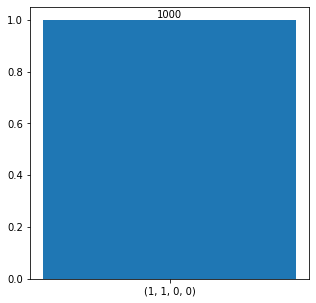

In [137]:
results = cirq.Simulator().run(circuit, repetitions=1000).multi_measurement_histogram(keys=qubits[:N])

plot_histogram(results)

Hemos sumado 9+3, y vemos que en asuencia de ruido, se ha medido el resultado 12 el 100% de las ejecuciones, por lo que el sumador funciona correctamete.

### AQFT

Para implementar el sumador con la AQFT, tenemos que repetir el apartado anterior pero limitando el número de rotaciones de la QFT por cada qubit.

Podemos usar la función que definimos en el ejercicio 2:

In [138]:
# Función que nos crea el circuito de la AQFT.
def AQFT(qubits, n_rot=2):

    N = len(qubits)
    circuit = cirq.Circuit()

    for i in range(N):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i + 1, min(i+n_rot+1, N)):
            circuit.append(cirq.CZ(qubits[j], qubits[i])**(0.5**(j-i)))

    return circuit

Creamos el circuito para el sumador de la misma forma que en el apartado anterior.

In [139]:
# Número de qubits de cada operando
N = 4

A = 0b0101  # Primer operando: 5
B = 0b0011  # Segundo operando: 3

qubits = cirq.LineQubit.range(2*N)
circuit = cirq.Circuit()

# Inicializamos los qubits opreando al valor que deseamos.
for i in range(N):
    
    if ((A >> N - i - 1) & 0x1) == 1:
        circuit.append(cirq.X(qubits[i]))

    if (B >> N - i - 1 & 0x1) == 1:
        circuit.append(cirq.X(qubits[N + i]))

qft_circ = AQFT(qubits[:N], n_rot=2)
circuit.append(qft_circ)

circuit.append(adder(qubits))
circuit.append(cirq.inverse(qft_circ))

# Medimos unicamente los qubits 0:3, que son los que contienen A+B
for qubit in qubits[:N]:
    circuit.append(cirq.measure(qubit))

Probamos a sumar 5 + 3.

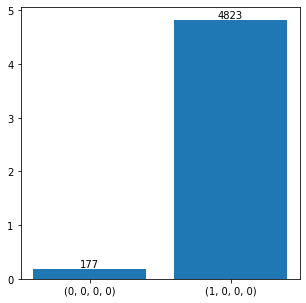

In [140]:
results = cirq.Simulator().run(circuit, repetitions=5000).multi_measurement_histogram(keys=qubits[:N])

plot_histogram(results)

Se aprecia aquí claramente el efecto de usar la AQFT en lugar de la QFT. Al utilizar un número límitado de rotaciones, existe una pequeña posibilidad de medir un resultado incorrecto. Vemos que en este caso, para dos rotaciones, hemos medido el resultado correcto un 96% de las veces, por lo que el resultado se puede dinstinguir perfectamente si se realizan varias repeticiones (shots).

Para confirmar esto, vamos a probar a realizar la misma suma de antes, pero con distinto número de rotaciones. Esperamos que, a medida que aumenta el número de rotaciones, disminuya el error considerablemente. Para poder hacer más pruebas, vamos a aumentar el número de qubits a 6.

Por comodidad, vamos a crear una función.

In [141]:
def draper(N: int, A: int, B: int, n_rot: int):


    qubits = cirq.LineQubit.range(2*N)
    circuit = cirq.Circuit()

    # Inicializamos los qubits opreando al valor que deseamos.
    for i in range(N):
        
        if ((A >> N - i - 1) & 0x1) == 1:
            circuit.append(cirq.X(qubits[i]))

        if (B >> N - i - 1 & 0x1) == 1:
            circuit.append(cirq.X(qubits[N + i]))

    qft_circ = AQFT(qubits[:N], n_rot=n_rot)
    circuit.append(qft_circ)

    circuit.append(adder(qubits))
    circuit.append(cirq.inverse(qft_circ))

    # Medimos unicamente los qubits 0:3, que son los que contienen A+B
    for qubit in qubits[:N]:
        circuit.append(cirq.measure(qubit))

    return circuit

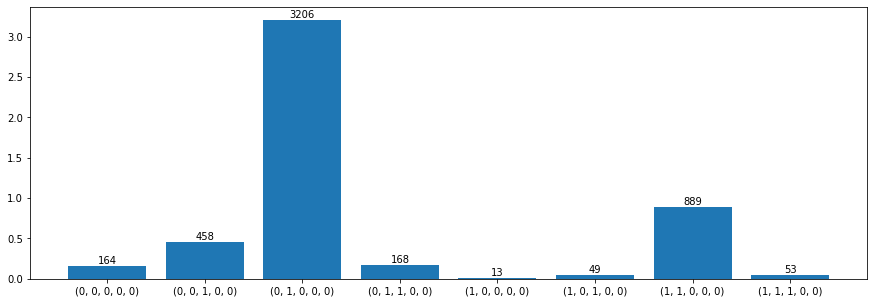

In [152]:
# Una rotación
N = 5
results = cirq.Simulator().run(draper(N, 0b0101, 0b0011, 1), repetitions=5000).multi_measurement_histogram(keys=qubits[:N])
plot_histogram(results, width=15)

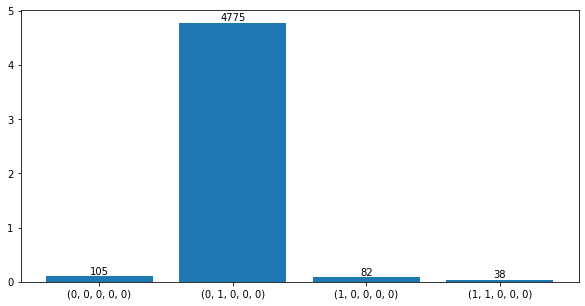

In [157]:
# Dos rotaciones
results = cirq.Simulator().run(draper(N, 0b0101, 0b0011, 2), repetitions=5000).multi_measurement_histogram(keys=qubits[:N])
plot_histogram(results, width=10)

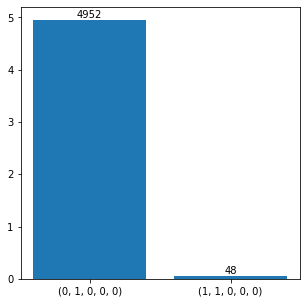

In [156]:
# Tres rotaciones
results = cirq.Simulator().run(draper(N, 0b0101, 0b0011, 3), repetitions=5000).multi_measurement_histogram(keys=qubits[:N])
plot_histogram(results)

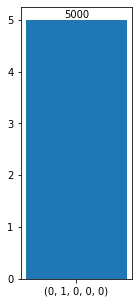

In [159]:
# Cuatro rotaciones
results = cirq.Simulator().run(draper(N, 0b0101, 0b0011, 4), repetitions=5000).multi_measurement_histogram(keys=qubits[:N])
plot_histogram(results, width=2)

Efectivamente, vemos que la posibilidad de medir un resultado incorrecto disminuye a medida que nos acercamos al número de rotaciones de la QFT normal. 

Una rotación quizás pueda ser insuficiente, pero vemos que con dos rotaciones ya se obtiene una tasa de éxito bastante alta.